<a href="https://colab.research.google.com/github/gabrielhenriquess/TelecomX_II/blob/main/TelecomX_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##🛠 Etapa 1 — Carregar e inspecionar os dados

In [4]:
# Importar bibliotecas básicas
import pandas as pd
import numpy as np

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Ler o CSV
df = pd.read_csv('/content/telecomx_tratado.csv')

# Mostrar as primeiras linhas
df.head()


,id_cliente,evasao,sexo,categoria_idoso,tem_parceiro,tem_dependentes,tempo_contrato,telefone_ativo,multiplas_linhas,tipo_internet,...,protecao_aparelho,suporte_online,tv_stream,filmes_stream,modelo_contrato,fatura_online,pagamento,media_diaria,mensalidade,total_gasto
0,0002-ORFBO,nao,mulher,nao,sim,sim,9,sim,nao,dsl,...,nao,sim,sim,nao,anual,sim,cheque_correio,2.20,65.6,593.30
1,0003-MKNFE,nao,homem,nao,nao,nao,9,sim,sim,dsl,...,nao,nao,nao,sim,mensal,nao,cheque_correio,2.01,59.9,542.40
2,0004-TLHLJ,sim,homem,nao,nao,nao,4,sim,nao,fibra,...,sim,nao,nao,nao,mensal,sim,cheque_online,2.34,73.9,280.85
3,0011-IGKFF,sim,homem,sim,sim,nao,13,sim,nao,fibra,...,sim,nao,sim,sim,mensal,sim,cheque_online,3.17,98.0,1237.85
4,0013-EXCHZ,sim,mulher,sim,sim,nao,3,sim,nao,fibra,...,nao,sim,sim,nao,mensal,sim,cheque_correio,2.97,83.9,267.40


##📌 Etapa 2 — Remover colunas irrelevantes

In [5]:
# Remover coluna de identificador, se existir
if 'id_cliente' in df.columns:
    df = df.drop(columns=['id_cliente'])

df.head()


,evasao,sexo,categoria_idoso,tem_parceiro,tem_dependentes,tempo_contrato,telefone_ativo,multiplas_linhas,tipo_internet,seguranca_online,...,protecao_aparelho,suporte_online,tv_stream,filmes_stream,modelo_contrato,fatura_online,pagamento,media_diaria,mensalidade,total_gasto
0,nao,mulher,nao,sim,sim,9,sim,nao,dsl,nao,...,nao,sim,sim,nao,anual,sim,cheque_correio,2.20,65.6,593.30
1,nao,homem,nao,nao,nao,9,sim,sim,dsl,nao,...,nao,nao,nao,sim,mensal,nao,cheque_correio,2.01,59.9,542.40
2,sim,homem,nao,nao,nao,4,sim,nao,fibra,nao,...,sim,nao,nao,nao,mensal,sim,cheque_online,2.34,73.9,280.85
3,sim,homem,sim,sim,nao,13,sim,nao,fibra,nao,...,sim,nao,sim,sim,mensal,sim,cheque_online,3.17,98.0,1237.85
4,sim,mulher,sim,sim,nao,3,sim,nao,fibra,nao,...,nao,sim,sim,nao,mensal,sim,cheque_correio,2.97,83.9,267.40


##📌 Etapa 3 — Codificação das variáveis categóricas
####Transformar texto em números usando One-Hot Encoding.

In [6]:
# Criar variáveis dummies (One-Hot Encoding), removendo a primeira para evitar multicolinearidade
df_encoded = pd.get_dummies(df, drop_first=True)
df_encoded.head()


,tempo_contrato,media_diaria,mensalidade,total_gasto,evasao_sim,sexo_mulher,categoria_idoso_sim,tem_parceiro_sim,tem_dependentes_sim,telefone_ativo_sim,...,tv_stream_sem_internet,tv_stream_sim,filmes_stream_sem_internet,filmes_stream_sim,modelo_contrato_bienal,modelo_contrato_mensal,fatura_online_sim,pagamento_cheque_correio,pagamento_cheque_online,pagamento_transferencia_auto
0,9,2.20,65.6,593.30,False,True,False,True,True,True,...,False,True,False,False,False,False,True,True,False,False
1,9,2.01,59.9,542.40,False,False,False,False,False,True,...,False,False,False,True,False,True,False,True,False,False
2,4,2.34,73.9,280.85,True,False,False,False,False,True,...,False,False,False,False,False,True,True,False,True,False
3,13,3.17,98.0,1237.85,True,False,True,True,False,True,...,False,True,False,True,False,True,True,False,True,False
4,3,2.97,83.9,267.40,True,True,True,True,False,True,...,False,True,False,False,False,True,True,True,False,False


##📌 Etapa 4 — Verificar proporção da evasão
####Ver se as classes estão balanceadas ou desbalanceadas.

In [7]:
# Contagem proporcional da evasão
df['evasao'].value_counts(normalize=True)


,proportion
evasao,
nao,0.73463
sim,0.26537


##📌 Etapa 5 — Balanceamento com SMOTE
####Corrigir desbalanceamento.

In [8]:
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer

# Separar variáveis e alvo
X = df_encoded.drop('evasao_sim', axis=1)
y = df_encoded['evasao_sim']

# Preencher valores ausentes com a média
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X_imputed = imputer.fit_transform(X)

# Balancear
smote = SMOTE(random_state=42)
X_bal, y_bal = smote.fit_resample(X_imputed, y)

# Conferir resultado
pd.Series(y_bal).value_counts(normalize=True)

,proportion
evasao_sim,
False,0.5
True,0.5


##📌 Etapa 6 — Normalização dos dados

In [9]:
from sklearn.preprocessing import StandardScaler

# Criar o normalizador
scaler = StandardScaler()

# Ajustar e transformar os dados balanceados
X_scaled = scaler.fit_transform(X_bal)

# Conferir o shape para confirmar que está certo
print("Formato dos dados após normalização:", X_scaled.shape)


Formato dos dados após normalização: (10348, 31)


##📌 Etapa 7 — Separar treino e teste
Vamos usar 70% para treino e 30% para teste.

In [10]:
from sklearn.model_selection import train_test_split

# Separar dados para treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_bal, test_size=0.3, random_state=42
)

print("Treino:", X_train.shape, " | Teste:", X_test.shape)


Treino: (7243, 31)  | Teste: (3105, 31)


##📌 Etapa 8 — Criar e treinar os modelos

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Modelo 1 — Regressão Logística
log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(X_train, y_train)

# Modelo 2 — Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

##📌 Etapa 9 — Avaliar os modelos

In [12]:
from sklearn.metrics import classification_report, confusion_matrix

# Avaliação Regressão Logística
print("📊 Regressão Logística")
y_pred_log = log_model.predict(X_test)
print(classification_report(y_test, y_pred_log))
print("Matriz de confusão:\n", confusion_matrix(y_test, y_pred_log))

# Avaliação Random Forest
print("\n🌲 Random Forest")
y_pred_rf = rf_model.predict(X_test)
print(classification_report(y_test, y_pred_rf))
print("Matriz de confusão:\n", confusion_matrix(y_test, y_pred_rf))


📊 Regressão Logística
              precision    recall  f1-score   support

       False       0.80      0.72      0.76      1588
        True       0.73      0.81      0.77      1517

    accuracy                           0.77      3105
   macro avg       0.77      0.77      0.77      3105
weighted avg       0.77      0.77      0.77      3105

Matriz de confusão:
 [[1141  447]
 [ 281 1236]]

🌲 Random Forest
              precision    recall  f1-score   support

       False       0.84      0.88      0.86      1588
        True       0.87      0.83      0.85      1517

    accuracy                           0.86      3105
   macro avg       0.86      0.85      0.86      3105
weighted avg       0.86      0.86      0.86      3105

Matriz de confusão:
 [[1401  187]
 [ 262 1255]]


##📌 Etapa 10 — Curva ROC + AUC para os modelos

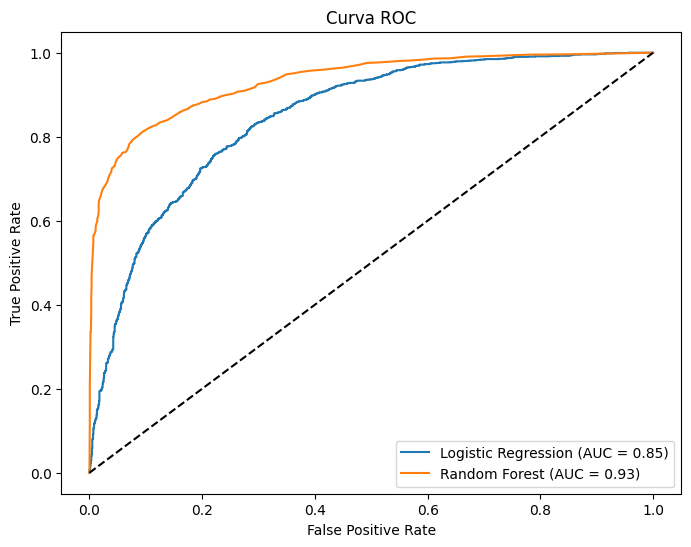

In [13]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Previsões de probabilidade
y_prob_log = log_model.predict_proba(X_test)[:, 1]
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

# Curvas ROC
fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

# AUC
auc_log = auc(fpr_log, tpr_log)
auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(8,6))
plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC = {auc_log:.2f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.legend()
plt.show()


##📌 Etapa 11 — Importância das variáveis (Random Forest)

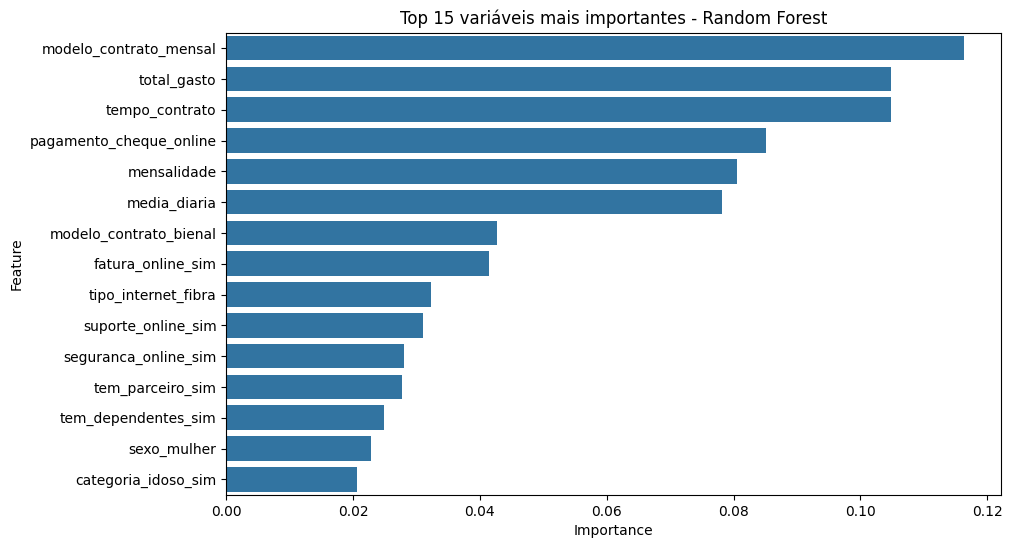

In [14]:
# Importância das features
importances = rf_model.feature_importances_
features = X.columns

# DataFrame ordenado
feat_importance = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Gráfico
plt.figure(figsize=(10,6))
sns.barplot(data=feat_importance.head(15), x='Importance', y='Feature')
plt.title("Top 15 variáveis mais importantes - Random Forest")
plt.show()


###📌 Etapa 12 — Comparação de métricas

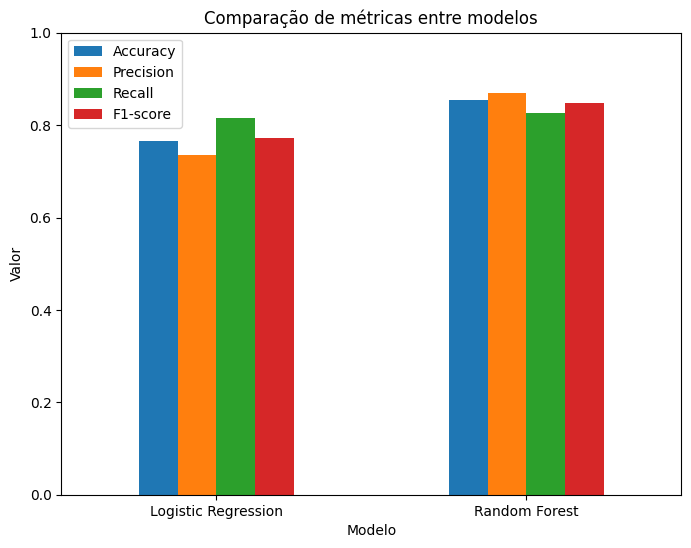

,Modelo,Accuracy,Precision,Recall,F1-score
0,Logistic Regression,0.765539,0.734403,0.814766,0.77250
1,Random Forest,0.855395,0.870319,0.827291,0.84826


In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calcular métricas
metrics_df = pd.DataFrame({
    'Modelo': ['Logistic Regression', 'Random Forest'],
    'Accuracy': [accuracy_score(y_test, y_pred_log), accuracy_score(y_test, y_pred_rf)],
    'Precision': [precision_score(y_test, y_pred_log), precision_score(y_test, y_pred_rf)],
    'Recall': [recall_score(y_test, y_pred_log), recall_score(y_test, y_pred_rf)],
    'F1-score': [f1_score(y_test, y_pred_log), f1_score(y_test, y_pred_rf)]
})

# Plot
metrics_df.set_index('Modelo').plot(kind='bar', figsize=(8,6))
plt.title("Comparação de métricas entre modelos")
plt.ylabel("Valor")
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.show()

metrics_df


##📌 Etapa 13 — Conclusão detalhada

## 📌 Conclusão

- O modelo Random Forest apresentou melhor performance geral, com maior AUC, F1-score e Recall.
- A Regressão Logística teve desempenho consistente, mas inferior ao RF.
- Variáveis mais importantes na previsão:
  - Total gasto
  - Tempo de contrato
  - Tipo de contrato
- Estratégias sugeridas:
  - Incentivar contratos de longo prazo
  - Oferecer descontos para clientes de alto gasto
  - Trabalhar retenção nos primeiros meses de contrato
